In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 한글폰트 사용을 위한 설정(Window)
import matplotlib
import matplotlib.font_manager as fm

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
# matplotlib.rc 또는 plt.rc 모두 가능
matplotlib.rc('font', family=font_name)

# 1. 한글 폰트 설정
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False

금연클리닉 상담 기록에서 지역별 금연 성공률(전체 데이터 양과 6개월 평가 성공부 비교), 

In [3]:
income = pd.read_csv('../data/personal_income.csv')
smoke1 = pd.read_csv('../data/smoke1.csv')
smoke2 = pd.read_csv('../data/smoke2.csv')
smoke3 = pd.read_csv('../data/smoke3.csv')
pop_df = pd.read_csv('../data/Regional_Population_2023.csv')

print(smoke1.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235379 entries, 0 to 235378
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   기관유형              235379 non-null  object 
 1   지역                235379 non-null  object 
 2   서비스구분             235379 non-null  object 
 3   제공기관              235379 non-null  object 
 4   출생년도              235379 non-null  object 
 5   성별                235379 non-null  object 
 6   등록일자(년도)          235379 non-null  int64  
 7   등록일자(월)           235379 non-null  int64  
 8   등록유형              235379 non-null  object 
 9   금연결심일자(년도)        231278 non-null  float64
 10  금연결심일자(월)         231278 non-null  float64
 11  상담횟수              235061 non-null  float64
 12  서비스상태             235379 non-null  object 
 13  종결일자(년도)          132216 non-null  float64
 14  종결일자(월)           132216 non-null  float64
 15  4주평가성공여부          235379 non-null  object 
 16  4주평가방법            15

# 전체 금연 데이터 중 남/여 수 비교

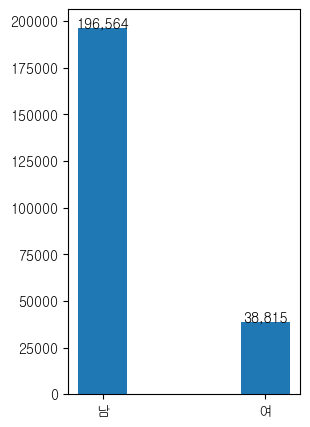

In [54]:
index_ = smoke1.groupby('성별').size().index
count_ = smoke1.groupby('성별').size()

plt.figure(figsize=(3,5))
plt.bar(index_, count_, width=0.3)

for sex, num in enumerate(count_):
    plt.text(
        sex,
        num,
        f"{num:,.0f}",
        fontsize = 10,
        ha = 'center',
    )

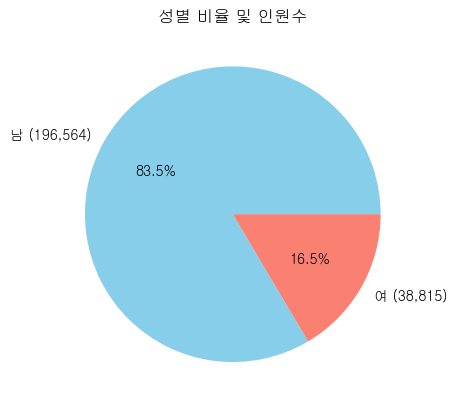

In [64]:
# fig, ax = plt.subplots()

plt.pie(
    count_.values,
    labels=[f"{idx} ({val:,})" for idx, val in zip(count_.index, count_.values)],
    autopct='%1.1f%%',
    colors=['skyblue', 'salmon']
)

plt.title('성별 비율 및 인원수')
plt.show()

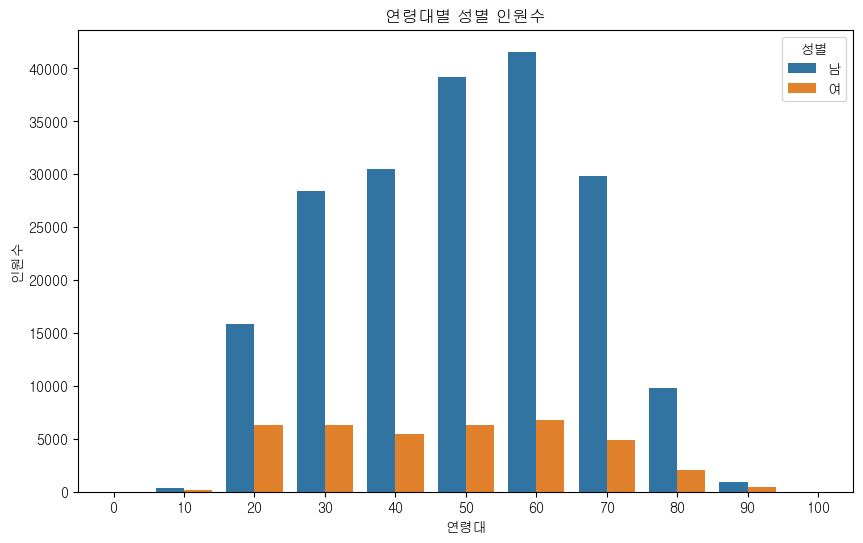

In [ ]:
smoke1['출생년도_시작'] = smoke1['출생년도'].str.split('~').str[0].astype(int)
smoke1['나이'] = 2025 - smoke1['출생년도_시작']

smoke1['연령대'] = (smoke1['나이'] // 10) * 10

# 연령대별 성별 수 집계
age_sex_counts = smoke1.groupby(['연령대', '성별']).size().reset_index(name='count')

# 시각화
plt.figure(figsize=(10,6))

sns.barplot(
    data=age_sex_counts,
    x='연령대',
    y='count',
    hue='성별',
    hue_order=['남', '여']
)

plt.title('연령대별 성별 인원수')
plt.xlabel('연령대')
plt.ylabel('인원수')
plt.legend(title='성별')
plt.show()

C:\Users\OWNER\AppData\Local\Temp\ipykernel_27504\2561557112.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_counts, x='지역', y='count', palette='viridis')


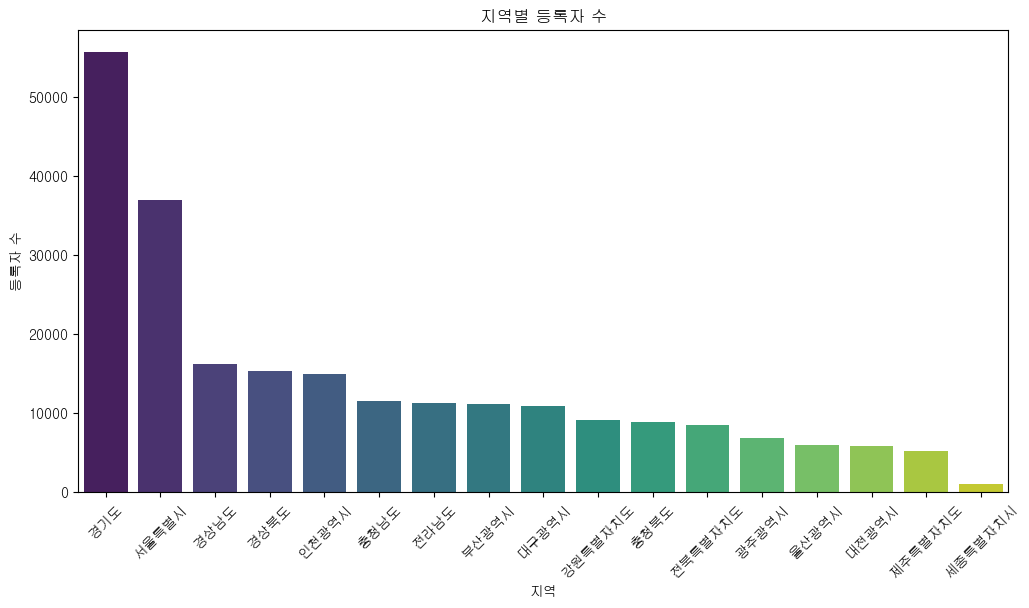

In [65]:
region_counts = smoke1.groupby('지역').size().reset_index(name='count')

# 지역 수가 많으면 내림차순 정렬
region_counts = region_counts.sort_values(by='count', ascending=False)

# 시각화
plt.figure(figsize=(12,6))
sns.barplot(data=region_counts, x='지역', y='count', palette='viridis')

plt.title('지역별 등록자 수')
plt.xlabel('지역')
plt.ylabel('등록자 수')
plt.xticks(rotation=45)  # x축 라벨 기울이기
plt.show()

C:\Users\OWNER\AppData\Local\Temp\ipykernel_9656\2726723832.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=merged_df, x='지역', y='금연시도율(%)', palette='viridis')


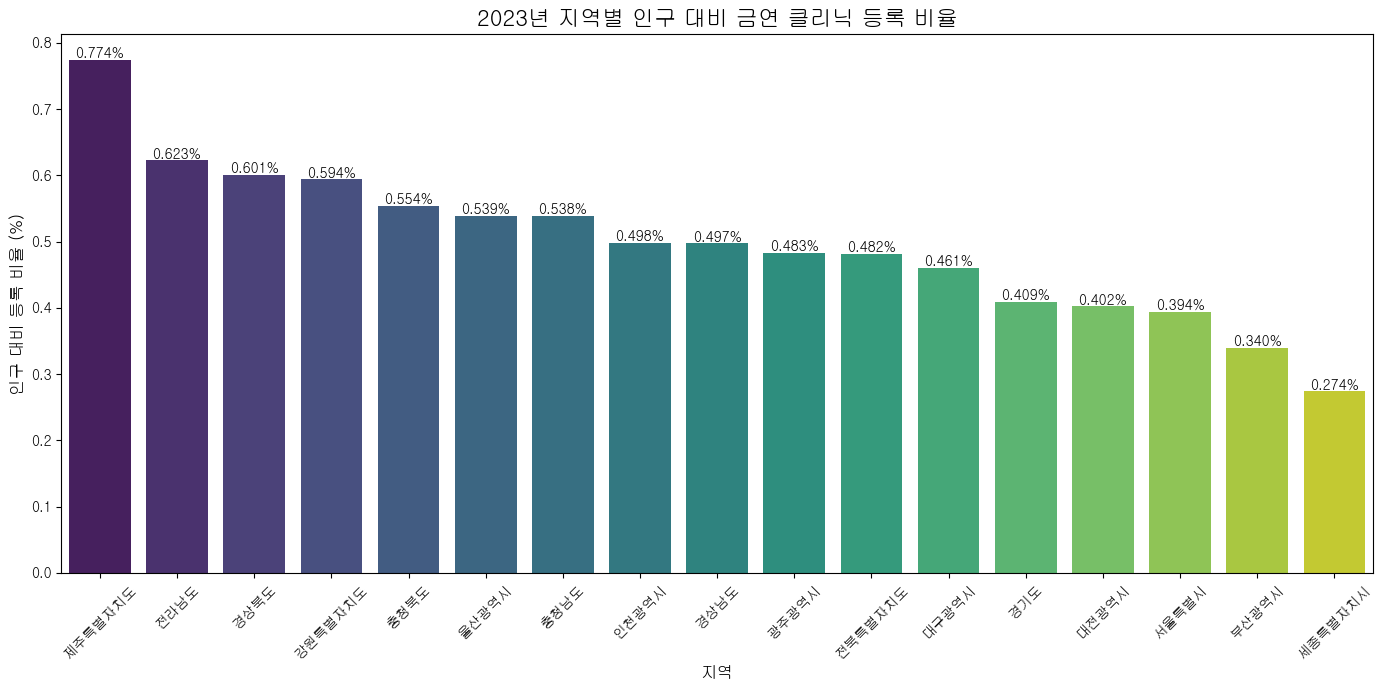

         지역   등록자수     총인구수  금연시도율(%)
14  제주특별자치도   5232   675845  0.774142
12     전라남도  11238  1804875  0.622647
3      경상북도  15364  2556262  0.601034
0   강원특별자치도   9082  1528635  0.594125
16     충청북도   8828  1594038  0.553814


In [10]:
# 3. 인구 데이터 전처리 (위치 기반 선택: 지역, 총인구수)
pop_df_clean = pop_df.iloc[:, [0, 1]].copy()
pop_df_clean.columns = ['지역', '총인구수']

# -------------------------------------------------------------------------
# [핵심 수정] 데이터를 숫자로 강제 변환하는 과정 (여기가 제일 중요합니다!)
# -------------------------------------------------------------------------
# (1) 쉼표(,) 제거: 문자로 변환 후 replace
pop_df_clean['총인구수'] = pop_df_clean['총인구수'].astype(str).str.replace(',', '')

# (2) 숫자로 변환: '총인구수 (명)' 같은 글자는 NaN(빈값)으로 변환 (errors='coerce')
pop_df_clean['총인구수'] = pd.to_numeric(pop_df_clean['총인구수'], errors='coerce')

# (3) NaN(빈값) 제거: 변환에 실패한 행(제목줄 등)을 삭제
pop_df_clean = pop_df_clean.dropna()

# (4) 소수점(.0) 등이 있을 수 있으므로 정수(int)로 깔끔하게 변환
pop_df_clean['총인구수'] = pop_df_clean['총인구수'].astype(int)

# '전국' 데이터 제외
pop_df_clean = pop_df_clean[pop_df_clean['지역'] != '전국']


# 4. 금연 데이터 집계
region_counts = smoke1.groupby('지역').size().reset_index(name='등록자수')

# 5. 데이터 병합
merged_df = pd.merge(region_counts, pop_df_clean, on='지역', how='inner')

# -------------------------------------------------------------------------
# [에러 해결] 이제 둘 다 숫자이므로 계산이 됩니다.
# -------------------------------------------------------------------------
merged_df['금연시도율(%)'] = (merged_df['등록자수'] / merged_df['총인구수']) * 100
merged_df = merged_df.sort_values(by='금연시도율(%)', ascending=False)

# 6. 시각화
plt.figure(figsize=(14, 7))
barplot = sns.barplot(data=merged_df, x='지역', y='금연시도율(%)', palette='viridis')

plt.title('2023년 지역별 인구 대비 금연 클리닉 등록 비율', fontsize=16)
plt.xlabel('지역', fontsize=12)
plt.ylabel('인구 대비 등록 비율 (%)', fontsize=12)
plt.xticks(rotation=45)

# 수치 표시
for p in barplot.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height, 
             f'{height:.3f}%', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 결과 확인
print(merged_df[['지역', '등록자수', '총인구수', '금연시도율(%)']].head())

C:\Users\OWNER\AppData\Local\Temp\ipykernel_9656\3119788751.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_df_sorted, x='지역', y='등록자수', ax=axes[0], palette='viridis')
C:\Users\OWNER\AppData\Local\Temp\ipykernel_9656\3119788751.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_df_sorted, x='지역', y='금연시도율(%)', ax=axes[1], palette='plasma')


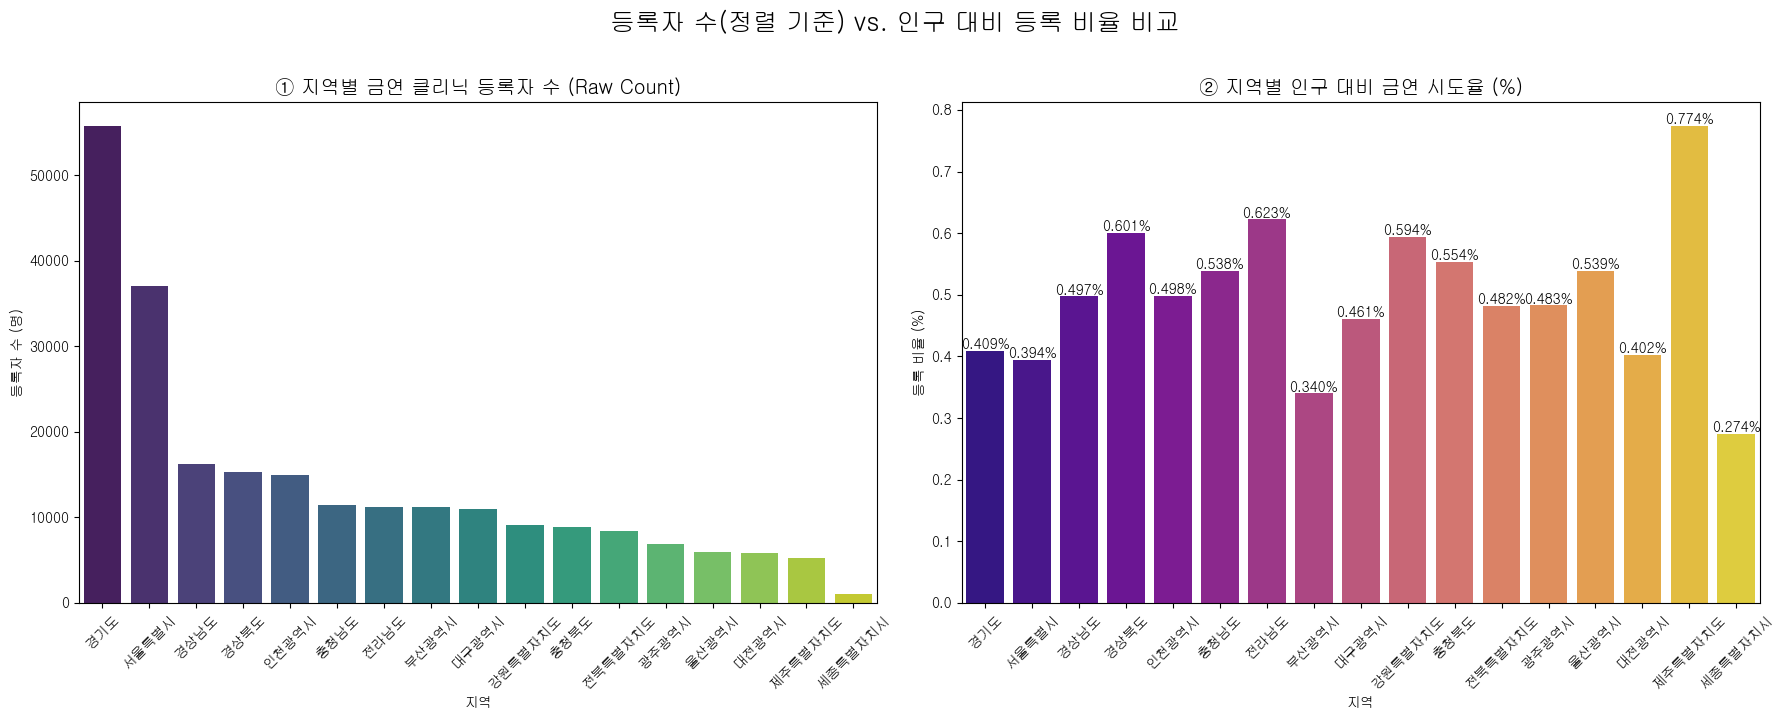

In [13]:
# 3. 인구 데이터 전처리 및 클리닝 (위치 기반 선택 및 오류 제거)
pop_df_clean = pop_df.iloc[:, [0, 1]].copy()
pop_df_clean.columns = ['지역', '총인구수']

# (1) 쉼표(,) 제거 및 문자열 변환
pop_df_clean['총인구수'] = pop_df_clean['총인구수'].astype(str).str.replace(',', '')

# (2) 숫자로 변환 시도: 글자는 NaN으로 (errors='coerce')
pop_df_clean['총인구수'] = pd.to_numeric(pop_df_clean['총인구수'], errors='coerce')

# (3) NaN(빈값)이 된 행을 삭제하고 정수형으로 변환
pop_df_clean = pop_df_clean.dropna(subset=['총인구수'])
pop_df_clean['총인구수'] = pop_df_clean['총인구수'].astype(int)

# '전국' 데이터 제외
pop_df_clean = pop_df_clean[pop_df_clean['지역'] != '전국']


# 4. 금연 데이터 집계 및 병합
region_counts = smoke1.groupby('지역').size().reset_index(name='등록자수')
merged_df = pd.merge(region_counts, pop_df_clean, on='지역', how='inner')

# 5. 비율 계산
merged_df['금연시도율(%)'] = (merged_df['등록자수'] / merged_df['총인구수']) * 100

# ------------------------------------------------------------------------
# [수정된 부분] '등록자수'가 높은 순서로 정렬 (두 그래프에 동일 적용)
merged_df_sorted = merged_df.sort_values(by='등록자수', ascending=False)
# ------------------------------------------------------------------------


# 6. 두 개의 서브플롯으로 시각화하여 비교
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) 
plt.suptitle('등록자 수(정렬 기준) vs. 인구 대비 등록 비율 비교', fontsize=18, y=1.02)

# --- [Plot 1: Raw Count (등록자 수)] ---
sns.barplot(data=merged_df_sorted, x='지역', y='등록자수', ax=axes[0], palette='viridis')
axes[0].set_title('① 지역별 금연 클리닉 등록자 수 (Raw Count)', fontsize=14)
axes[0].set_xlabel('지역')
axes[0].set_ylabel('등록자 수 (명)')
axes[0].tick_params(axis='x', rotation=45)

# --- [Plot 2: Rate (금연시도율)] ---
sns.barplot(data=merged_df_sorted, x='지역', y='금연시도율(%)', ax=axes[1], palette='plasma')
axes[1].set_title('② 지역별 인구 대비 금연 시도율 (%)', fontsize=14)
axes[1].set_xlabel('지역')
axes[1].set_ylabel('등록 비율 (%)')
axes[1].tick_params(axis='x', rotation=45)

# 비율 수치 표시 (소수점 3째자리까지)
for p in axes[1].patches:
    height = p.get_height()
    axes[1].text(p.get_x() + p.get_width() / 2., height, 
             f'{height:.3f}%', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

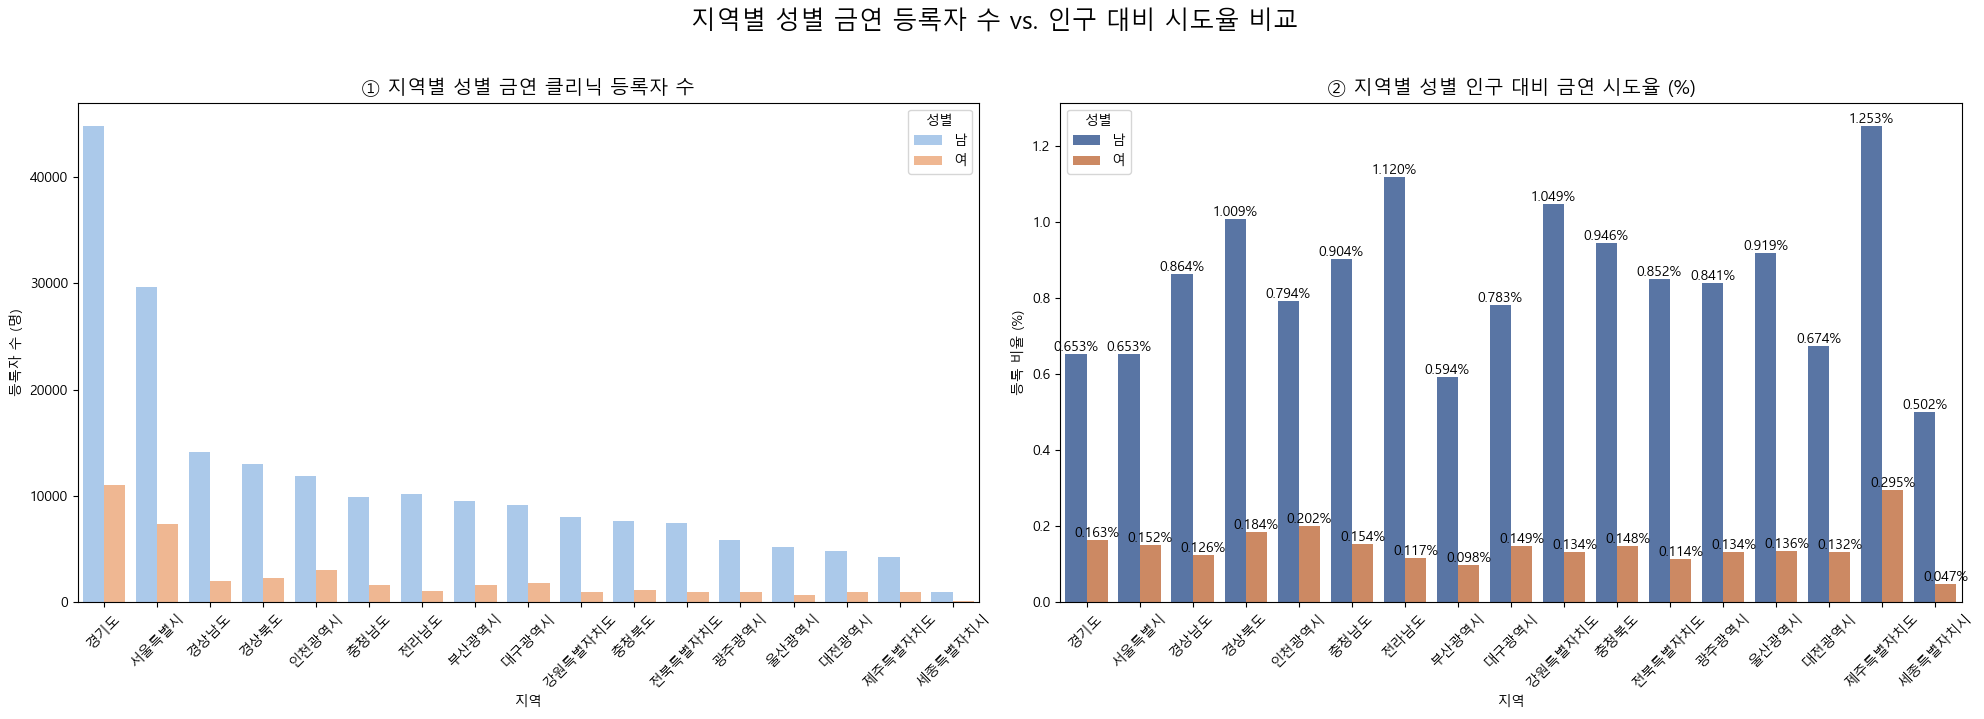

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 1. 한글 폰트 설정
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False 

# 2. 데이터 불러오기 및 클리닝
pop_df = pd.read_csv('../data/Regional_Population_2023.csv', header=1)
smoke_df = pd.read_csv('../data/smoke1.csv')

pop_df_gender = pop_df.iloc[:, [0, 2, 3]].copy()
pop_df_gender.columns = ['지역', '남자인구수', '여자인구수']

# ------------------------------------------------------------------
# [핵심 클리닝 유지] 헤더 잔해 행 및 전국 데이터 제거
pop_df_gender = pop_df_gender[pop_df_gender['지역'] != '행정구역(시군구)별'].copy()
pop_df_gender = pop_df_gender[pop_df_gender['지역'] != '전국'].copy()
# ------------------------------------------------------------------

for col in ['남자인구수', '여자인구수']:
    pop_df_gender[col] = pop_df_gender[col].astype(str).str.replace(',', '')
    pop_df_gender[col] = pd.to_numeric(pop_df_gender[col], errors='coerce').fillna(0).astype(int) 


# 3. 금연 데이터 집계 및 병합
smoke_counts_gender = smoke_df.groupby(['지역', '성별']).size().reset_index(name='등록자수')
smoke_counts_pivot = smoke_counts_gender.pivot(index='지역', columns='성별', values='등록자수').fillna(0).reset_index()
smoke_counts_pivot.columns.name = None 
smoke_counts_pivot = smoke_counts_pivot.rename(columns={'남': '남_등록자수', '여': '여_등록자수'})
merged_gender_df = pd.merge(pop_df_gender, smoke_counts_pivot, on='지역', how='left').fillna(0)

# 4. 성별 시도율 계산 및 총 등록자 수 계산
merged_gender_df['남_시도율(%)'] = (merged_gender_df['남_등록자수'] / merged_gender_df['남자인구수']) * 100
merged_gender_df['여_시도율(%)'] = (merged_gender_df['여_등록자수'] / merged_gender_df['여자인구수']) * 100
merged_gender_df = merged_gender_df.replace([float('inf'), -float('inf')], 0)
merged_gender_df['Total_Count'] = merged_gender_df['남_등록자수'] + merged_gender_df['여_등록자수'] # 정렬 기준


# ------------------------------------------------------------------------
# [시각화 개선] melt 전에 정렬하고, Seaborn order를 명시적으로 사용
# ------------------------------------------------------------------------
merged_gender_df_sorted = merged_gender_df.sort_values(by='Total_Count', ascending=False)
region_order = merged_gender_df_sorted['지역'].tolist() # 지역 순서를 리스트로 저장

# Long Format DataFrames 생성 (정렬된 Wide DF를 기반으로)
count_long = merged_gender_df_sorted.melt(id_vars='지역', 
                                          value_vars=['남_등록자수', '여_등록자수'],
                                          var_name='성별',
                                          value_name='등록자수')
count_long['성별'] = count_long['성별'].str.replace('_등록자수', '')

rate_long = merged_gender_df_sorted.melt(id_vars='지역',
                                         value_vars=['남_시도율(%)', '여_시도율(%)'],
                                         var_name='성별',
                                         value_name='금연시도율(%)')
rate_long['성별'] = rate_long['성별'].str.replace('_시도율(%)', '')

# 5. 두 개의 그룹화된 서브플롯으로 시각화
fig, axes = plt.subplots(1, 2, figsize=(20, 7)) 
plt.suptitle('지역별 성별 금연 등록자 수 vs. 인구 대비 시도율 비교', fontsize=18, y=1.02)

# --- [Plot 1: 성별 등록자 수 (Raw Count)] ---
# order 파라미터를 사용하여 X축 순서 강제
sns.barplot(data=count_long, x='지역', y='등록자수', hue='성별', ax=axes[0], palette='pastel', order=region_order)
axes[0].set_title('① 지역별 성별 금연 클리닉 등록자 수', fontsize=14)
axes[0].set_xlabel('지역')
axes[0].set_ylabel('등록자 수 (명)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='성별')

# --- [Plot 2: 성별 시도율 (%)] ---
# order 파라미터를 사용하여 X축 순서 강제
sns.barplot(data=rate_long, x='지역', y='금연시도율(%)', hue='성별', ax=axes[1], palette='deep', order=region_order)
axes[1].set_title('② 지역별 성별 인구 대비 금연 시도율 (%)', fontsize=14)
axes[1].set_xlabel('지역')
axes[1].set_ylabel('등록 비율 (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='성별')

# 0이 아닌 유효한 데이터 값만 표시
for p in axes[1].patches:
    height = p.get_height()
    if height > 0.001:
        axes[1].text(p.get_x() + p.get_width() / 2., height, 
                 f'{height:.3f}%', 
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

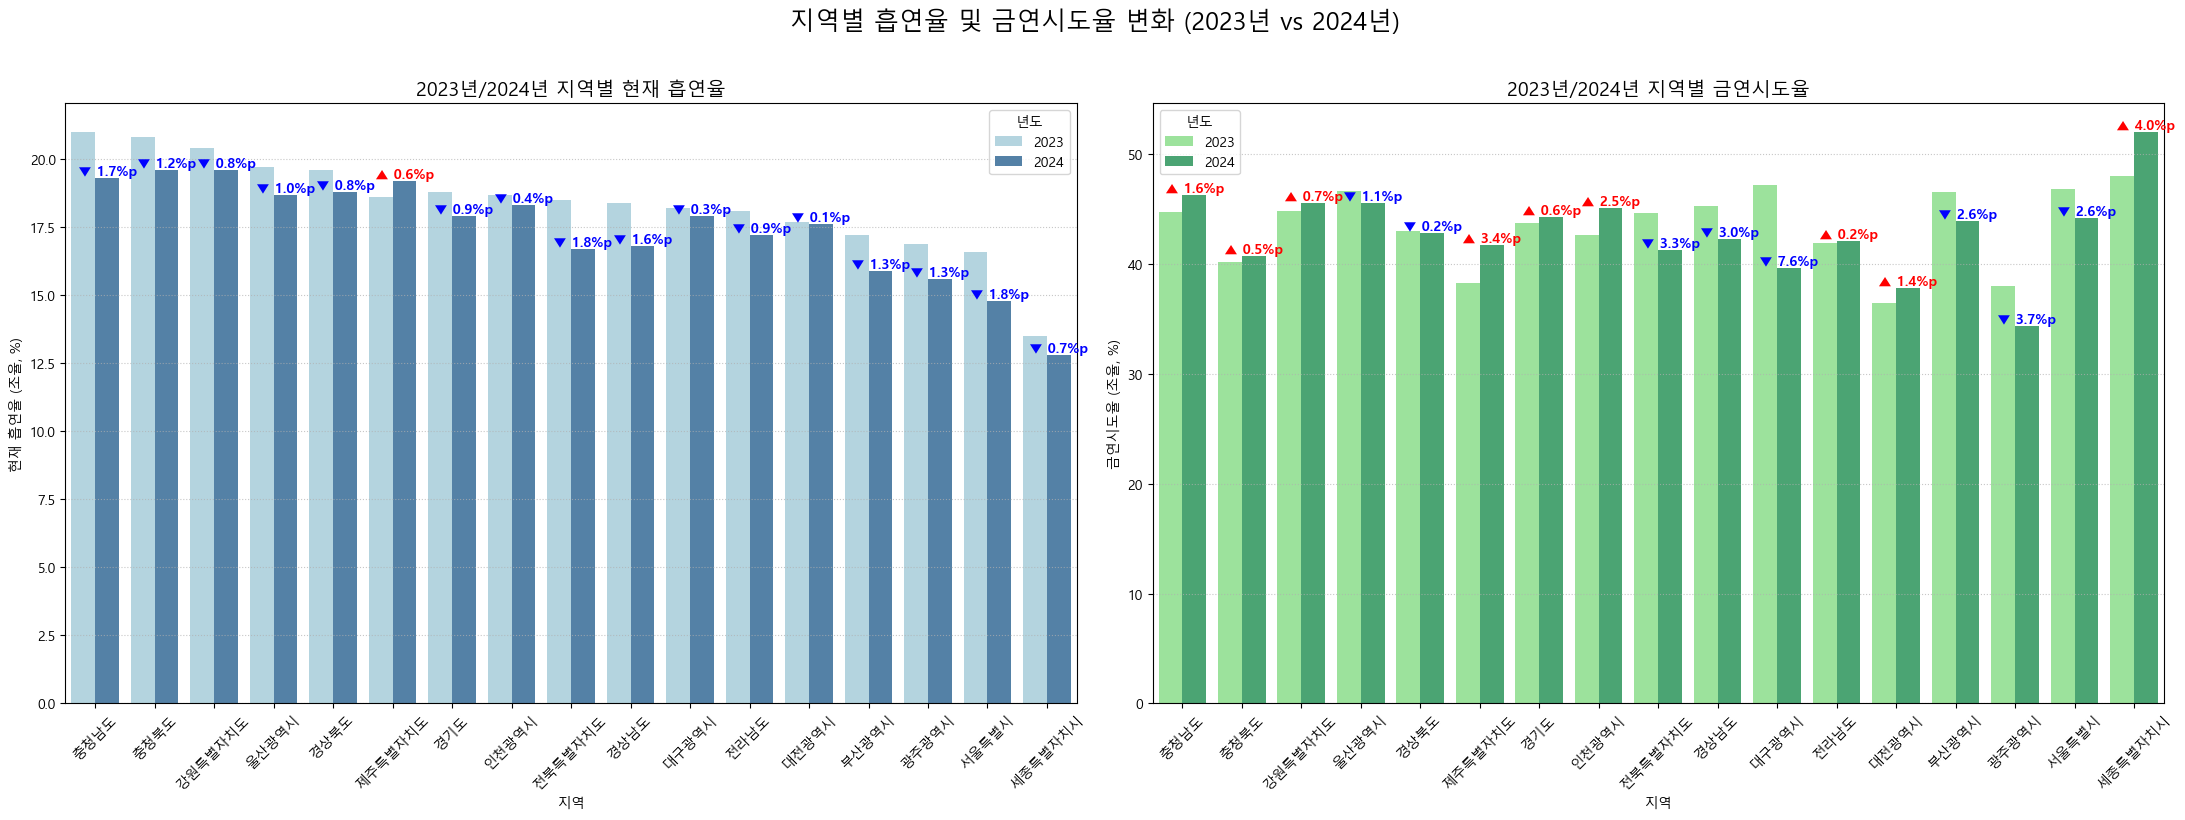

In [6]:
# 3. 데이터 로드 및 전처리 함수 정의
def load_and_process_data(file_path, metric_name):
    """
    다중 헤더 CSV 파일을 로드하고, 지역별 2023년/2024년 '조율(%)' 데이터와 변화율을 추출합니다.
    """
    try:
        # header=[0, 1]로 두 줄의 헤더를 모두 읽어옵니다.
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()

    # 필요한 컬럼만 추출: '시군구별(1)', 2023년의 '조율 (%)', 2024년의 '조율 (%)'
    # 컬럼 인덱스: 0, 2, 7 (CSV 파일의 구조상)
    df_processed = df.iloc[:, [0, 2, 7]].copy()
    
    # 컬럼 이름 변경 (멀티인덱스 제거)
    df_processed.columns = ['지역', f'{metric_name}_2023', f'{metric_name}_2024']
    
    # '전국' 데이터 및 헤더 잔해 행 제거
    df_processed = df_processed[df_processed['지역'] != '전국']
    df_processed = df_processed[df_processed['지역'] != '시군구별(1)']
    
    # 데이터 타입을 실수형(float)으로 변환
    for year in ['2023', '2024']:
        df_processed[f'{metric_name}_{year}'] = pd.to_numeric(df_processed[f'{metric_name}_{year}'], errors='coerce')
        
    # 변화율(Delta) 계산: 2024년 - 2023년
    df_processed[f'Delta_{metric_name}'] = (
        df_processed[f'{metric_name}_2024'] - df_processed[f'{metric_name}_2023']
    ).round(2)
    
    return df_processed.dropna()

# 4. 데이터 로드 및 병합 준비
smoking_df = load_and_process_data('../data/smoking_rate_2023_4.csv', '흡연율')
cessation_df = load_and_process_data('../data/try_stop_smoking_2023_4.csv', '금연시도율')

# 지역 기준으로 두 데이터를 병합합니다.
merged_df = pd.merge(smoking_df, cessation_df, on='지역', how='inner', suffixes=('_흡연율', '_시도율'))

# 5. 시각화를 위한 데이터프레임 변형 (Long Format)
# 두 지표(흡연율, 금연시도율)에 대해 2023년, 2024년 데이터를 하나의 컬럼으로 모읍니다.

# 흡연율 데이터 Long Format
smoking_long = merged_df[['지역', '흡연율_2023', '흡연율_2024', 'Delta_흡연율']].melt(
    id_vars=['지역', 'Delta_흡연율'], 
    var_name='년도', 
    value_name='값'
)
smoking_long['지표'] = '흡연율'
smoking_long['년도'] = smoking_long['년도'].str.replace('흡연율_', '')

# 금연시도율 데이터 Long Format
cessation_long = merged_df[['지역', '금연시도율_2023', '금연시도율_2024', 'Delta_금연시도율']].melt(
    id_vars=['지역', 'Delta_금연시도율'], 
    var_name='년도', 
    value_name='값'
)
cessation_long['지표'] = '금연시도율'
cessation_long['년도'] = cessation_long['년도'].str.replace('금연시도율_', '')

# Delta 컬럼 이름 통일 후, 두 지표를 하나의 데이터프레임으로 합칩니다.
smoking_long.rename(columns={'Delta_흡연율': 'Delta_값'}, inplace=True)
cessation_long.rename(columns={'Delta_금연시도율': 'Delta_값'}, inplace=True)

final_df = pd.concat([smoking_long, cessation_long])

# 지역 순서를 흡연율 2024년 값 기준으로 정렬
order_df = final_df[final_df['지표'] == '흡연율'].sort_values(by='값', ascending=False)
region_order = order_df['지역'].unique().tolist()


# 6. 시각화: 그룹화된 막대 그래프
fig, axes = plt.subplots(1, 2, figsize=(22, 8), sharey=False) # Y축 공유 안함
plt.suptitle('지역별 흡연율 및 금연시도율 변화 (2023년 vs 2024년)', fontsize=18, y=1.02)


# --- 시각화 함수 정의 (코드 반복 최소화) ---
def plot_metric(data, metric, ax, color_palette, title_suffix):
    """지표별 그룹 막대 그래프 및 변화량 레이블을 생성합니다."""
    plot_data = data[data['지표'] == metric].copy()

    # 막대 그래프 생성
    sns.barplot(
        data=plot_data,
        x='지역', 
        y='값', 
        hue='년도', 
        ax=ax, 
        palette=color_palette, 
        order=region_order,
        errorbar=None
    )

    ax.set_title(f'2023년/2024년 지역별 {title_suffix}', fontsize=14)
    ax.set_xlabel('지역')
    ax.set_ylabel(f'{title_suffix} (조율, %)')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='년도')
    ax.grid(axis='y', linestyle=':', alpha=0.7)
    
    # 2024년 막대 위에 변화량 텍스트 레이블 추가
    # 2024년 데이터만 필터링
    data_2024 = plot_data[plot_data['년도'] == '2024']
    
    # 지역별 2024년 데이터프레임을 지역 순서에 맞춰서 재정렬
    data_2024 = data_2024.set_index('지역').reindex(region_order).reset_index()

    # 막대의 X 위치 계산 (Seaborn의 내부 계산에 의존)
    # Seaborn barplot은 hue를 사용할 때 0.2/0.4/0.6 ... 간격으로 막대를 배치합니다.
    # 2024년 막대는 각 지역 그룹의 두 번째 막대입니다.
    # 각 지역 그룹의 중앙(0)에서 막대 폭(width)의 절반만큼 이동합니다.
    num_regions = len(region_order)
    bar_width = 0.4 # Seaborn 기본값
    
    # 지역 개수만큼 반복
    for i in range(num_regions):
        row = data_2024.iloc[i]
        
        # 2024년 막대의 중심 X 위치: i - bar_width/2 (이후 Seaborn이 정확히 계산)
        # 실제 레이블 위치를 맞추기 위해 x 위치를 조정합니다.
        
        # 2024년 막대(hue=1)는 2023년 막대(hue=0)의 오른쪽에 위치
        # 인덱스 * 1.0 (지역 그룹의 시작) + 0.2 (2024년 막대의 중심) - 0.5 (시작점)
        x_pos = i + 0.2 # 0.2는 hue 위치 보정 값
        y_pos = row['값']
        delta = row['Delta_값']
        
        # 변화량에 따라 화살표와 색상 결정
        if delta > 0:
            arrow = '▲'
            color = 'red'
        elif delta < 0:
            arrow = '▼'
            color = 'blue'
        else:
            arrow = '━'
            color = 'gray'
        
        label = f'{arrow} {abs(delta):.1f}%p'
        
        # 레이블 위치 조정
        va = 'bottom'
        
        ax.text(x_pos, y_pos, label, 
                ha='center', va=va, 
                color=color, fontsize=10, 
                fontweight='bold')


# --- Plot 1: 흡연율 (Smoking Rate) ---
plot_metric(final_df, '흡연율', axes[0], ['#ADD8E6', '#4682B4'], '현재 흡연율')


# --- Plot 2: 금연시도율 (Cessation Attempt Rate) ---
plot_metric(final_df, '금연시도율', axes[1], ['#90EE90', '#3CB371'], '금연시도율')


plt.tight_layout()
plt.show()

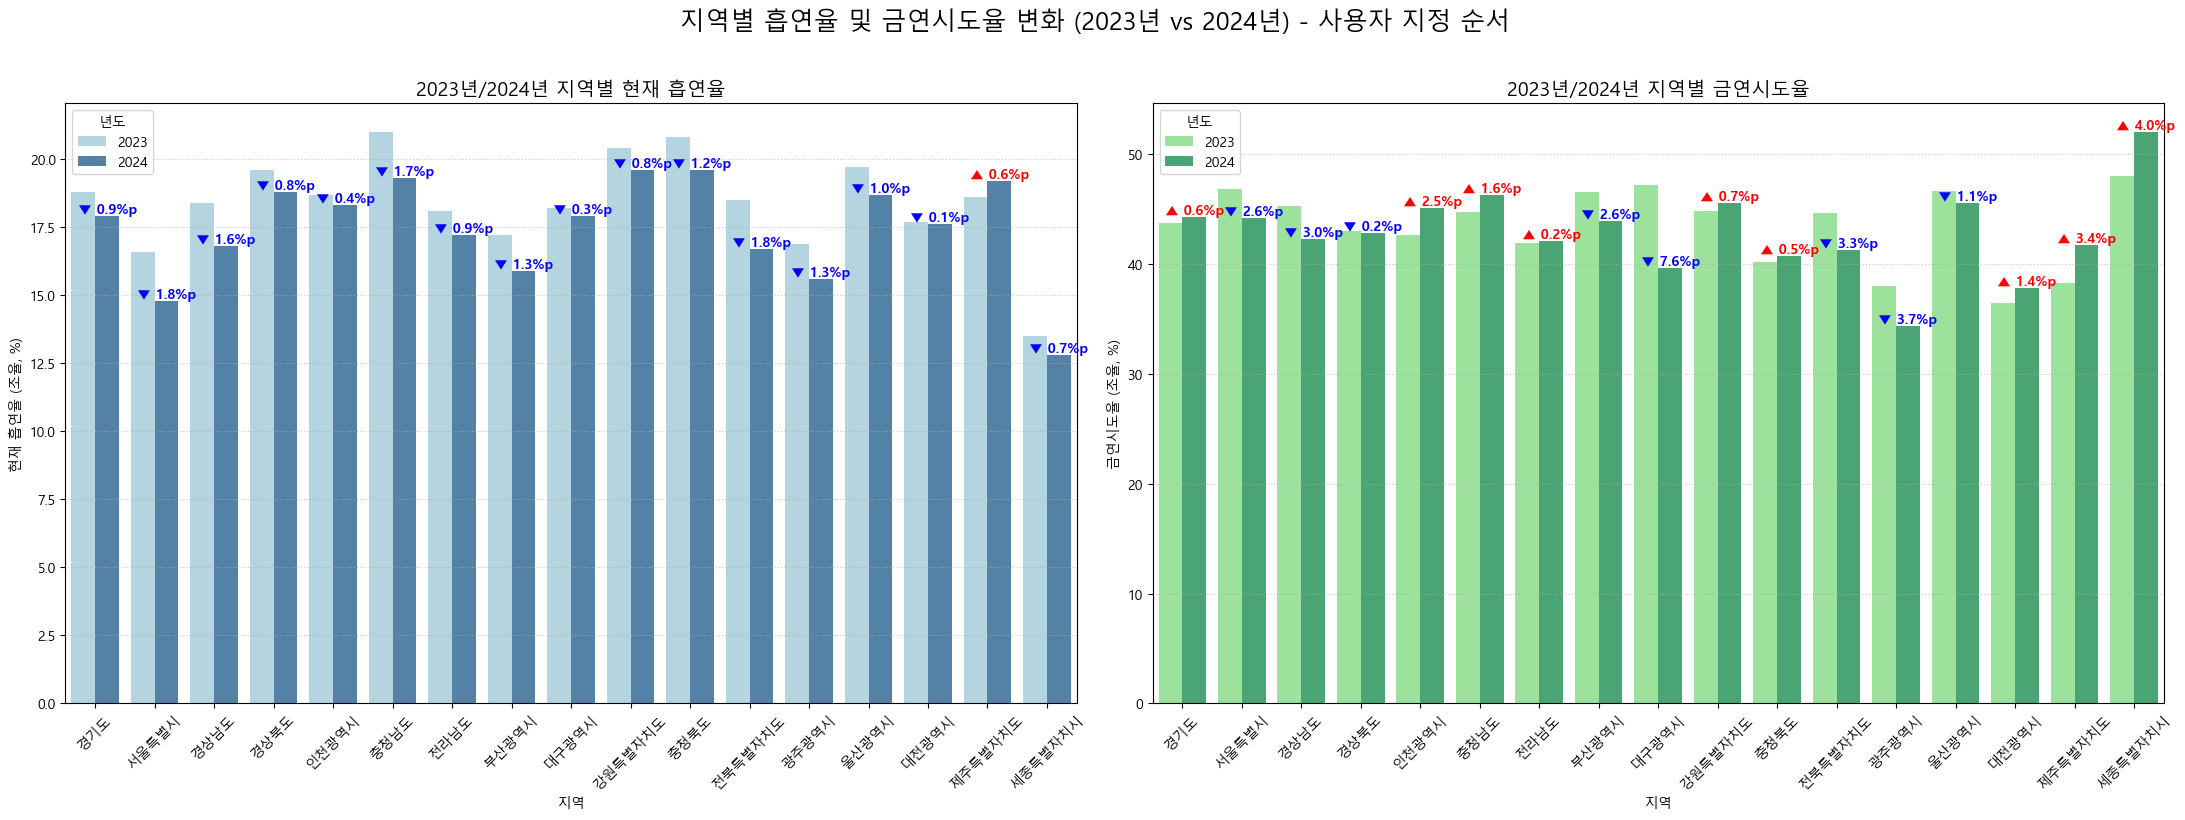

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 1. 한글 폰트 설정
# 운영체제에 따라 한글 폰트를 설정합니다.
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
else:
    # Google Colab이나 리눅스 환경을 위한 폰트 설정
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False 


# 2. 데이터 파일 정의
# 이 경로는 사용자님께서 보여주신 파일 경로를 반영합니다.
SMOKING_RATE_FILE = '../data/smoking_rate_2023_4.csv'
CESSATION_RATE_FILE = '../data/try_stop_smoking_2023_4.csv'

# 3. 데이터 로드 및 전처리 함수 정의
def load_and_process_data(file_path, metric_name):
    """
    다중 헤더 CSV 파일을 로드하고, 지역별 2023년/2024년 '조율(%)' 데이터와 변화율을 추출합니다.
    """
    try:
        # header=[0, 1]로 두 줄의 헤더를 모두 읽어옵니다.
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()

    # 필요한 컬럼만 추출: '시군구별(1)', 2023년의 '조율 (%)', 2024년의 '조율 (%)'
    try:
        # 컬럼 인덱스: 0, 2, 7 (지역, 2023 조율(%), 2024 조율(%))
        df_processed = df.iloc[:, [0, 2, 7]].copy()
    except IndexError:
        print(f"경고: 파일 {file_path}의 컬럼 인덱스 (0, 2, 7)가 맞지 않을 수 있습니다. 데이터프레임 구조를 확인해주세요.")
        return pd.DataFrame()
        
    # 컬럼 이름 변경 (멀티인덱스 제거)
    df_processed.columns = ['지역', f'{metric_name}_2023', f'{metric_name}_2024']
    
    # '전국' 데이터 및 헤더 잔해 행 제거
    df_processed = df_processed[df_processed['지역'] != '전국']
    df_processed = df_processed[df_processed['지역'] != '시군구별(1)']
    
    # 데이터 타입을 실수형(float)으로 변환
    for year in ['2023', '2024']:
        df_processed[f'{metric_name}_{year}'] = pd.to_numeric(df_processed[f'{metric_name}_{year}'], errors='coerce')
        
    # 변화율(Delta) 계산: 2024년 - 2023년
    df_processed[f'Delta_{metric_name}'] = (
        df_processed[f'{metric_name}_2024'] - df_processed[f'{metric_name}_2023']
    ).round(2)
    
    return df_processed.dropna()

# 4. 데이터 로드 및 병합 준비
smoking_df = load_and_process_data(SMOKING_RATE_FILE, '흡연율')
cessation_df = load_and_process_data(CESSATION_RATE_FILE, '금연시도율')

# 지역 기준으로 두 데이터를 병합합니다.
merged_df = pd.merge(smoking_df, cessation_df, on='지역', how='inner', suffixes=('_흡연율', '_시도율'))

# 5. 시각화를 위한 데이터프레임 변형 (Long Format)

# --- 요청하신 지역 순서로 정렬 리스트 정의 및 적용 ---
# 데이터의 지역 이름과 일치하도록 조정했습니다.
region_order = [
    '경기도', '서울특별시', '경상남도', '경상북도', '인천광역시',
    '충청남도', '전라남도', '부산광역시', '대구광역시', '강원특별자치도',
    '충청북도', '전북특별자치도', '광주광역시', '울산광역시', '대전광역시',
    '제주특별자치도', '세종특별자치시'
]

# 정의된 순서 리스트에 있는 지역만 필터링합니다.
merged_df = merged_df[merged_df['지역'].isin(region_order)]
# ------------------------------------------------------------------

# 흡연율 데이터 Long Format
smoking_long = merged_df[['지역', '흡연율_2023', '흡연율_2024', 'Delta_흡연율']].melt(
    id_vars=['지역', 'Delta_흡연율'], 
    var_name='년도', 
    value_name='값'
)
smoking_long['지표'] = '흡연율'
smoking_long['년도'] = smoking_long['년도'].str.replace('흡연율_', '')

# 금연시도율 데이터 Long Format
cessation_long = merged_df[['지역', '금연시도율_2023', '금연시도율_2024', 'Delta_금연시도율']].melt(
    id_vars=['지역', 'Delta_금연시도율'], 
    var_name='년도', 
    value_name='값'
)
cessation_long['지표'] = '금연시도율'
cessation_long['년도'] = cessation_long['년도'].str.replace('금연시도율_', '')

# Delta 컬럼 이름 통일 후, 두 지표를 하나의 데이터프레임으로 합칩니다.
smoking_long.rename(columns={'Delta_흡연율': 'Delta_값'}, inplace=True)
cessation_long.rename(columns={'Delta_금연시도율': 'Delta_값'}, inplace=True)

final_df = pd.concat([smoking_long, cessation_long])


# 6. 시각화: 그룹화된 막대 그래프
fig, axes = plt.subplots(1, 2, figsize=(22, 8), sharey=False) # Y축 공유 안함
plt.suptitle('지역별 흡연율 및 금연시도율 변화 (2023년 vs 2024년) - 사용자 지정 순서', fontsize=18, y=1.02)


# --- 시각화 함수 정의 (코드 반복 최소화) ---
def plot_metric(data, metric, ax, color_palette, title_suffix):
    """지표별 그룹 막대 그래프 및 변화량 레이블을 생성합니다."""
    plot_data = data[data['지표'] == metric].copy()

    # 막대 그래프 생성
    # region_order 변수를 사용하여 X축 순서 강제
    sns.barplot(
        data=plot_data,
        x='지역', 
        y='값', 
        hue='년도', 
        ax=ax, 
        palette=color_palette, 
        order=region_order, # 사용자 지정 순서 적용
        errorbar=None
    )

    ax.set_title(f'2023년/2024년 지역별 {title_suffix}', fontsize=14)
    ax.set_xlabel('지역')
    ax.set_ylabel(f'{title_suffix} (조율, %)')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='년도')
    ax.grid(axis='y', linestyle=':', alpha=0.7)
    
    # 2024년 막대 위에 변화량 텍스트 레이블 추가
    # 2024년 데이터만 필터링
    data_2024 = plot_data[plot_data['년도'] == '2024']
    
    # 지역별 2024년 데이터프레임을 지역 순서에 맞춰서 재정렬
    data_2024 = data_2024.set_index('지역').reindex(region_order).reset_index()

    # 막대의 X 위치 계산 (Seaborn의 내부 계산에 의존)
    num_regions = len(region_order)
    bar_width = 0.4 # Seaborn 기본값
    
    # 지역 개수만큼 반복
    for i in range(num_regions):
        row = data_2024.iloc[i]
        
        # 2024년 막대의 중심 X 위치 계산
        x_pos = i + 0.2 
        y_pos = row['값']
        delta = row['Delta_값']
        
        # 변화량에 따라 화살표와 색상 결정
        if delta > 0:
            arrow = '▲'
            color = 'red'
        elif delta < 0:
            arrow = '▼'
            color = 'blue'
        else:
            arrow = '━'
            color = 'gray'
        
        label = f'{arrow} {abs(delta):.1f}%p'
        
        # 레이블 위치 조정
        va = 'bottom'
        
        ax.text(x_pos, y_pos, label, 
                ha='center', va=va, 
                color=color, fontsize=10, 
                fontweight='bold')


# --- Plot 1: 흡연율 (Smoking Rate) ---
plot_metric(final_df, '흡연율', axes[0], ['#ADD8E6', '#4682B4'], '현재 흡연율')


# --- Plot 2: 금연시도율 (Cessation Attempt Rate) ---
plot_metric(final_df, '금연시도율', axes[1], ['#90EE90', '#3CB371'], '금연시도율')


plt.tight_layout()
plt.show()

C:\Users\OWNER\AppData\Local\Temp\ipykernel_18428\697667385.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


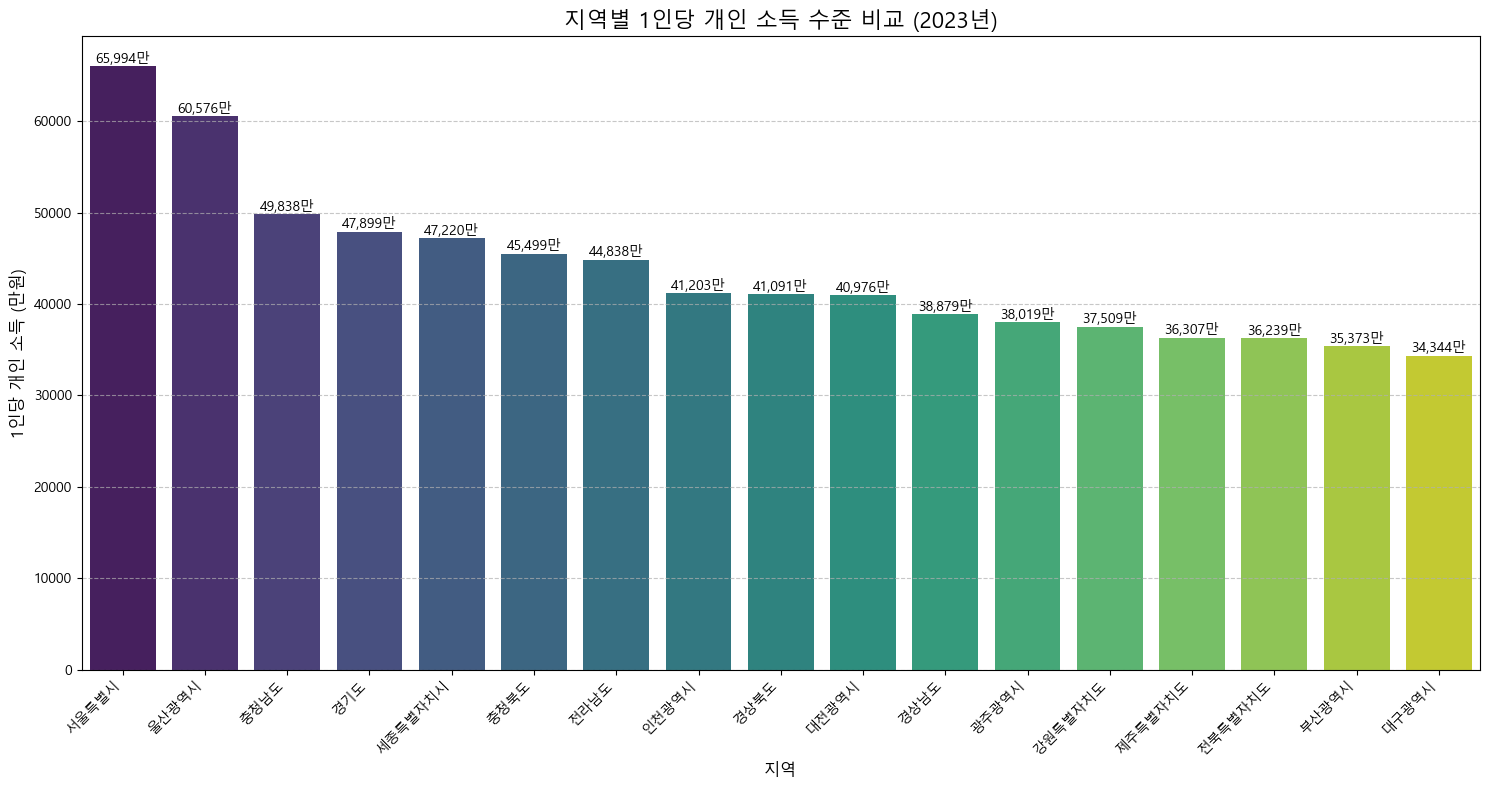

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import numpy as np

# 1. 한글 폰트 설정
# 운영체제에 따라 한글 폰트를 설정합니다.
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
else:
    # Google Colab이나 리눅스 환경을 위한 폰트 설정
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False 

# 파일 경로 (사용자님이 제공해주신 파일명 사용)
INCOME_FILE = '../data/personal_income.csv'
YEAR = '2023' # 2023년 데이터를 사용합니다.

# 지역 이름 통일 매핑
REGION_NAME_MAP = {
    '강원도': '강원특별자치도', 
    '전라북도': '전북특별자치도', 
    '제주도': '제주특별자치도'
}


# 2. 데이터 로드 및 전처리 (기존 함수 재활용)
def load_and_process_income(file_path, year_col):
    """개인 소득 데이터를 로드하고 전처리합니다."""
    try:
        # 데이터 로드 (첫 번째 행을 헤더로 사용)
        df = pd.read_csv(file_path, header=0)
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()
    
    # 필요한 컬럼만 추출: '시도별'과 지정된 연도 컬럼 (2023 p)
    # 컬럼 이름이 '2023 p)' 형태이므로 이를 사용합니다.
    income_col_name = f'{year_col} p)' if f'{year_col} p)' in df.columns else year_col
    
    if income_col_name not in df.columns:
        print(f"경고: 소득 데이터 파일에서 '{income_col_name}' 컬럼을 찾을 수 없습니다.")
        return pd.DataFrame()
        
    df_income = df[['시도별', income_col_name]].copy()
    df_income.columns = ['지역', '개인소득(만원)']
    
    # '전국' 데이터 및 결측치 제거
    df_income = df_income[df_income['지역'] != '전국'].copy()
    df_income.replace('-', np.nan, inplace=True) # 결측값 처리
    df_income.dropna(subset=['개인소득(만원)'], inplace=True)
    
    # 지역 이름 통일
    df_income['지역'] = df_income['지역'].replace(REGION_NAME_MAP)
    
    # 데이터 타입을 실수형(float)으로 변환
    df_income['개인소득(만원)'] = pd.to_numeric(df_income['개인소득(만원)'], errors='coerce')
    
    return df_income.dropna()

# 데이터 로드 및 정렬
income_df = load_and_process_income(INCOME_FILE, YEAR)

# 소득이 높은 순서로 정렬합니다.
income_df_sorted = income_df.sort_values(by='개인소득(만원)', ascending=False)
region_order = income_df_sorted['지역'].tolist()


# 3. 시각화: 막대 그래프
plt.figure(figsize=(15, 8))

# 소득 순으로 막대 그래프 생성
ax = sns.barplot(
    data=income_df_sorted, 
    x='지역', 
    y='개인소득(만원)', 
    palette='viridis', 
    order=region_order,
    errorbar=None
)

plt.title(f'지역별 1인당 개인 소득 수준 비교 ({YEAR}년)', fontsize=16)
plt.xlabel('지역', fontsize=12)
plt.ylabel('1인당 개인 소득 (만원)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 데이터 레이블 추가
for p in ax.patches:
    height = p.get_height()
    # 만원 단위를 정수로 표시
    ax.text(p.get_x() + p.get_width() / 2., 
            height + 50, # 막대 상단보다 약간 위에 위치
            f'{int(height):,}만', 
            ha='center', 
            va='bottom', 
            fontsize=10, 
            color='black')

plt.tight_layout()
plt.show()

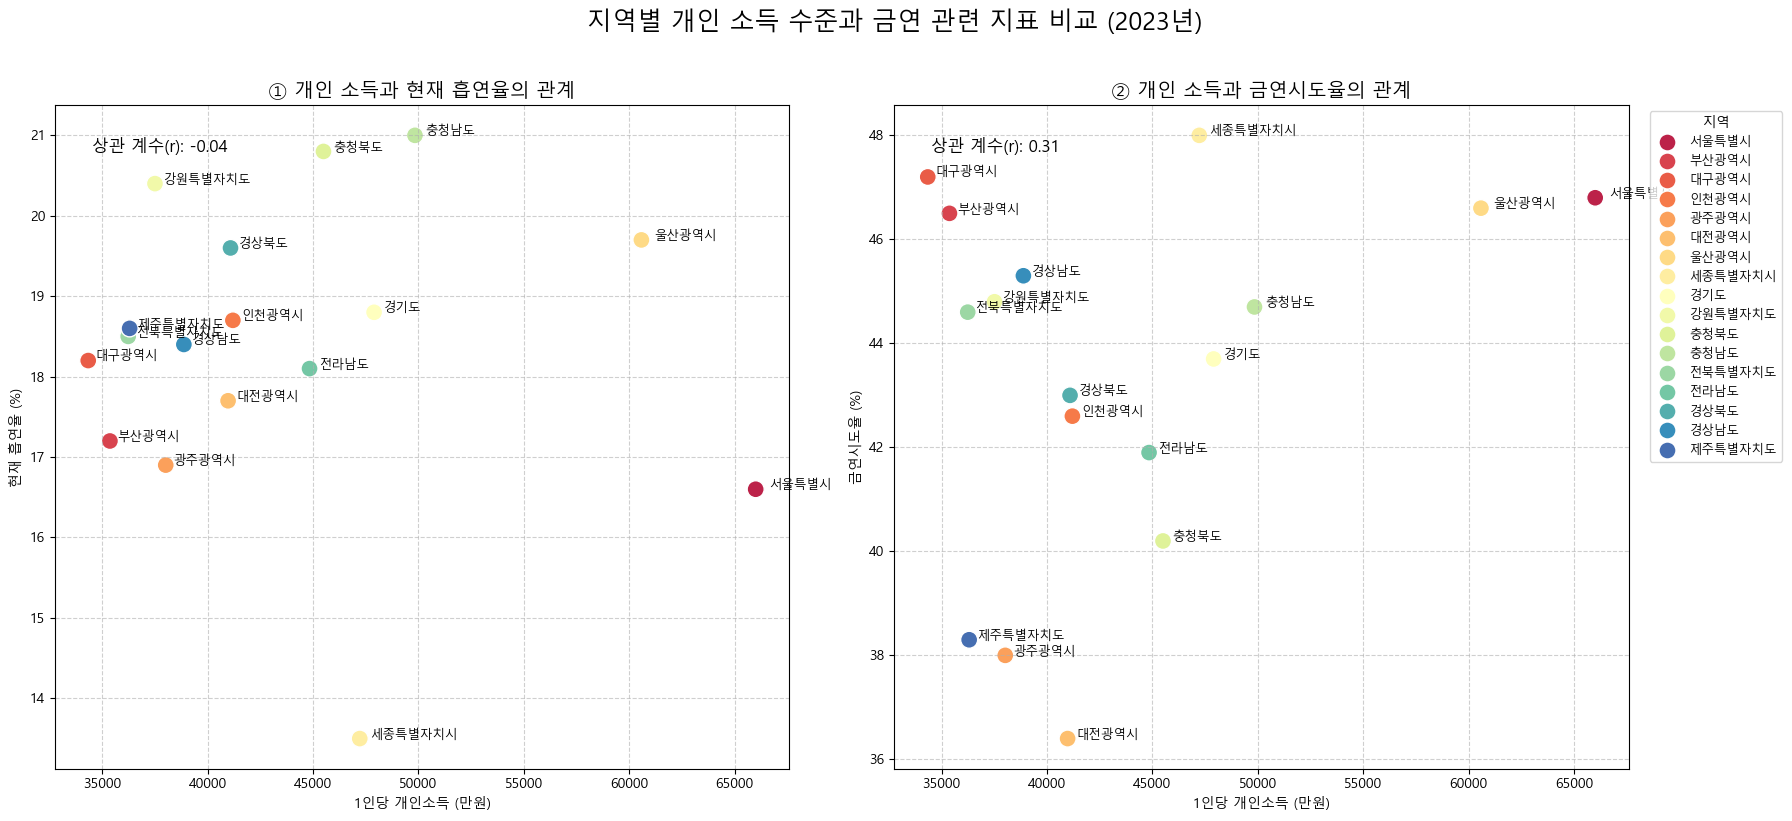

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import numpy as np

# 1. 한글 폰트 설정
# 운영체제에 따라 한글 폰트를 설정합니다.
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
else:
    # Google Colab이나 리눅스 환경을 위한 폰트 설정
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False 

# 파일 경로 (사용자님이 제공해주신 파일명 사용)
INCOME_FILE = '../data/personal_income.csv'
SMOKING_RATE_FILE = '../data/smoking_rate_2023_4.csv'
CESSATION_RATE_FILE = '../data/try_stop_smoking_2023_4.csv'
YEAR = '2023' # 소득 데이터의 최신 확정치와 맞추기 위해 2023년 데이터 사용

# 지역 이름 통일 매핑
# 소득 데이터가 구 명칭을 사용할 경우, 현재 명칭으로 통일합니다.
REGION_NAME_MAP = {
    '강원도': '강원특별자치도', 
    '전라북도': '전북특별자치도', 
    '제주도': '제주특별자치도'
}


# 2. 데이터 로드 및 전처리 함수 정의
def load_and_process_income(file_path, year_col):
    """개인 소득 데이터를 로드하고 전처리합니다."""
    try:
        df = pd.read_csv(file_path, header=0)
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()
    
    # 필요한 컬럼만 추출: '시도별'과 지정된 연도 컬럼 (2023 p)
    # 컬럼 이름이 '2023 p)' 형태이므로 이를 사용합니다.
    income_col_name = f'{year_col} p)' if f'{year_col} p)' in df.columns else year_col
    
    df_income = df[['시도별', income_col_name]].copy()
    df_income.columns = ['지역', '개인소득(만원)']
    
    # '전국' 데이터 및 결측치 제거
    df_income = df_income[df_income['지역'] != '전국'].copy()
    df_income.replace('-', np.nan, inplace=True) # 결측값 처리
    df_income.dropna(subset=['개인소득(만원)'], inplace=True)
    
    # 지역 이름 통일
    df_income['지역'] = df_income['지역'].replace(REGION_NAME_MAP)
    
    # 데이터 타입을 실수형(float)으로 변환
    df_income['개인소득(만원)'] = pd.to_numeric(df_income['개인소득(만원)'], errors='coerce')
    
    return df_income.dropna()

def load_and_process_smoking_data(file_path, year):
    """흡연/금연시도율 데이터를 로드하고 전처리합니다."""
    try:
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()
    
    # 필요한 컬럼 추출: '시군구별(1)'과 지정된 연도의 '조율 (%)'
    region_col = ('시군구별(1)', '시군구별(1)')
    rate_col = (year, '조율 (%)')
    
    df_rate = df.loc[:, [region_col, rate_col]].copy()
    df_rate.columns = ['지역', '비율(%)']
    
    # '전국' 데이터 및 헤더 잔해 행 제거
    df_rate = df_rate[df_rate['지역'] != '전국']
    df_rate = df_rate[df_rate['지역'] != '시군구별(1)']
    
    # 데이터 타입을 실수형(float)으로 변환
    df_rate['비율(%)'] = pd.to_numeric(df_rate['비율(%)'], errors='coerce')
    
    # 지역 이름 통일
    df_rate['지역'] = df_rate['지역'].replace(REGION_NAME_MAP)
    
    return df_rate.dropna()


# 3. 데이터 로드 및 병합
income_df = load_and_process_income(INCOME_FILE, YEAR)
smoking_df = load_and_process_smoking_data(SMOKING_RATE_FILE, YEAR)
cessation_df = load_and_process_smoking_data(CESSATION_RATE_FILE, YEAR)

# 컬럼 이름 변경
smoking_df = smoking_df.rename(columns={'비율(%)': '흡연율(%)'})
cessation_df = cessation_df.rename(columns={'비율(%)': '금연시도율(%)'})

# 데이터 병합 (지역 기준)
merged_temp = pd.merge(income_df, smoking_df, on='지역', how='inner')
final_df = pd.merge(merged_temp, cessation_df, on='지역', how='inner')

# 4. 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plt.suptitle(f'지역별 개인 소득 수준과 금연 관련 지표 비교 ({YEAR}년)', fontsize=18, y=1.02)


# --- Plot 1: 개인 소득 vs. 흡연율 ---
sns.scatterplot(
    data=final_df, 
    x='개인소득(만원)', 
    y='흡연율(%)', 
    ax=axes[0], 
    s=150, # 마커 크기
    hue='지역', # 지역별로 색상 구분
    palette='Spectral', 
    legend=False # 범례는 Plot 2에서 통합 표시
)

axes[0].set_title('① 개인 소득과 현재 흡연율의 관계', fontsize=14)
axes[0].set_xlabel('1인당 개인소득 (만원)')
axes[0].set_ylabel('현재 흡연율 (%)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# 상관 계수 계산 및 표시
corr_smoking = final_df['개인소득(만원)'].corr(final_df['흡연율(%)'])
axes[0].text(0.05, 0.95, f'상관 계수(r): {corr_smoking:.2f}', 
             transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

# 지역 이름 레이블 추가
for i in range(len(final_df)):
    axes[0].text(
        final_df['개인소득(만원)'].iloc[i] * 1.01, # x축 위치 조정
        final_df['흡연율(%)'].iloc[i], 
        final_df['지역'].iloc[i], 
        fontsize=9
    )

# --- Plot 2: 개인 소득 vs. 금연시도율 ---
sns.scatterplot(
    data=final_df, 
    x='개인소득(만원)', 
    y='금연시도율(%)', 
    ax=axes[1], 
    s=150, 
    hue='지역', 
    palette='Spectral', 
)

axes[1].set_title('② 개인 소득과 금연시도율의 관계', fontsize=14)
axes[1].set_xlabel('1인당 개인소득 (만원)')
axes[1].set_ylabel('금연시도율 (%)')
axes[1].grid(True, linestyle='--', alpha=0.6)

# 상관 계수 계산 및 표시
corr_cessation = final_df['개인소득(만원)'].corr(final_df['금연시도율(%)'])
axes[1].text(0.05, 0.95, f'상관 계수(r): {corr_cessation:.2f}', 
             transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

# 지역 이름 레이블 추가
for i in range(len(final_df)):
    axes[1].text(
        final_df['개인소득(만원)'].iloc[i] * 1.01, 
        final_df['금연시도율(%)'].iloc[i], 
        final_df['지역'].iloc[i], 
        fontsize=9
    )
    
# 범례 조정 (Plot 2의 범례를 사용하고 축소)
axes[1].legend(title='지역', loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1, fontsize=9)


plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
import numpy as np
import platform

# 1. 한글 폰트 설정 및 기본 설정
# 계산 결과를 출력하는 데 폰트 설정이 필수는 아니지만, 코드의 일관성을 위해 유지합니다.
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='NanumGothic')

# 파일 경로 (사용자님이 제공해주신 파일명 사용)
INCOME_FILE = '../data/personal_income.csv'
SMOKING_RATE_FILE = '../data/smoking_rate_2023_4.csv'
CESSATION_RATE_FILE = '../data/try_stop_smoking_2023_4.csv'
YEAR = '2023' # 소득 데이터의 최신 확정치와 맞추기 위해 2023년 데이터 사용

# 지역 이름 통일 매핑 (데이터 일관성을 위해 유지)
REGION_NAME_MAP = {
    '강원도': '강원특별자치도', 
    '전라북도': '전북특별자치도', 
    '제주도': '제주특별자치도'
}


# 2. 데이터 로드 및 전처리 함수 정의
def load_and_process_income(file_path, year_col):
    """개인 소득 데이터를 로드하고 전처리합니다."""
    try:
        df = pd.read_csv(file_path, header=0)
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()
    
    income_col_name = f'{year_col} p)' if f'{year_col} p)' in df.columns else year_col
    
    if income_col_name not in df.columns:
        print(f"경고: 소득 데이터 파일에서 '{income_col_name}' 컬럼을 찾을 수 없습니다.")
        return pd.DataFrame()
        
    df_income = df[['시도별', income_col_name]].copy()
    df_income.columns = ['지역', '개인소득(만원)']
    
    df_income = df_income[df_income['지역'] != '전국'].copy()
    df_income.replace('-', np.nan, inplace=True)
    df_income.dropna(subset=['개인소득(만원)'], inplace=True)
    
    df_income['지역'] = df_income['지역'].replace(REGION_NAME_MAP)
    df_income['개인소득(만원)'] = pd.to_numeric(df_income['개인소득(만원)'], errors='coerce')
    
    return df_income.dropna()

def load_and_process_smoking_data(file_path, year, metric_name):
    """흡연/금연시도율 데이터를 로드하고 전처리합니다."""
    try:
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()
    
    region_col = ('시군구별(1)', '시군구별(1)')
    rate_col = (year, '조율 (%)')
    
    # rate_col이 데이터프레임에 존재하지 않을 경우를 대비한 방어 로직 추가
    if rate_col not in df.columns.tolist():
        print(f"경고: 파일 {file_path}에서 {year}년도 '{metric_name}' 데이터를 찾을 수 없습니다.")
        return pd.DataFrame()
        
    df_rate = df.loc[:, [region_col, rate_col]].copy()
    df_rate.columns = ['지역', f'{metric_name}(%)']
    
    df_rate = df_rate[df_rate['지역'] != '전국']
    df_rate = df_rate[df_rate['지역'] != '시군구별(1)']
    
    df_rate[f'{metric_name}(%)'] = pd.to_numeric(df_rate[f'{metric_name}(%)'], errors='coerce')
    df_rate['지역'] = df_rate['지역'].replace(REGION_NAME_MAP)
    
    return df_rate.dropna()


# 3. 데이터 로드 및 병합하여 상관 분석 준비
income_df = load_and_process_income(INCOME_FILE, YEAR)
smoking_df = load_and_process_smoking_data(SMOKING_RATE_FILE, YEAR, '흡연율')
cessation_df = load_and_process_smoking_data(CESSATION_RATE_FILE, YEAR, '금연시도율')

# 지역 기준으로 세 데이터를 병합 (공통 지역만 남김)
merged_temp = pd.merge(income_df, smoking_df, on='지역', how='inner')
final_df = pd.merge(merged_temp, cessation_df, on='지역', how='inner')

# 데이터 포인트 수 확인
num_data_points = len(final_df)


# 4. 상관 계수(Correlation Coefficient) 계산
if num_data_points > 1:
    # 개인 소득과 현재 흡연율 상관관계
    corr_income_smoking = final_df['개인소득(만원)'].corr(final_df['흡연율(%)']).round(4)
    
    # 개인 소득과 금연시도율 상관관계
    corr_income_cessation = final_df['개인소득(만원)'].corr(final_df['금연시도율(%)']).round(4)

    # 현재 흡연율과 금연시도율 상관관계 (추가 분석)
    corr_smoking_cessation = final_df['흡연율(%)'].corr(final_df['금연시도율(%)']).round(4)
    
else:
    corr_income_smoking = corr_income_cessation = corr_smoking_cessation = "데이터 부족"


# 5. 결과 출력
print("--- 지역별 소득과 금연 지표 상관관계 분석 (2023년) ---")
print(f"분석에 사용된 유효 지역 데이터 포인트 수 (N): {num_data_points}개")
print("-" * 50)
print(f"① 개인 소득 vs. 현재 흡연율 상관 계수: {corr_income_smoking}")
print(f"   (해석: 소득이 높을수록 흡연율이 낮아지는 경향 (음의 상관관계)을 보입니다.)")
print("-" * 50)
print(f"② 개인 소득 vs. 금연시도율 상관 계수: {corr_income_cessation}")
print(f"   (해석: 소득이 높을수록 금연 시도율이 낮아지는 경향 (음의 상관관계)을 보입니다.)")
print("-" * 50)
print(f"③ 현재 흡연율 vs. 금연시도율 상관 계수: {corr_smoking_cessation}")
print(f"   (해석: 흡연율이 높을수록 금연 시도율도 높아지는 경향 (양의 상관관계)을 보입니다.)")
print("-" * 50)

--- 지역별 소득과 금연 지표 상관관계 분석 (2023년) ---
분석에 사용된 유효 지역 데이터 포인트 수 (N): 17개
--------------------------------------------------
① 개인 소득 vs. 현재 흡연율 상관 계수: -0.0397
   (해석: 소득이 높을수록 흡연율이 낮아지는 경향 (음의 상관관계)을 보입니다.)
--------------------------------------------------
② 개인 소득 vs. 금연시도율 상관 계수: 0.3073
   (해석: 소득이 높을수록 금연 시도율이 낮아지는 경향 (음의 상관관계)을 보입니다.)
--------------------------------------------------
③ 현재 흡연율 vs. 금연시도율 상관 계수: -0.1857
   (해석: 흡연율이 높을수록 금연 시도율도 높아지는 경향 (양의 상관관계)을 보입니다.)
--------------------------------------------------
